# MIKSERI Accessibility Zones

Short description in Finnish: 
*Palveluiden kävelysaavutettavuusvyöhykkeiden muodostaminen Python-ohjelmointikielellä. Osa [MIKSERI-hankkeen](https://www.syke.fi/hankkeet/mikseri) analyysejä*. 

This document contains the workflow for calculating the amount of servise within a defined walking distance zone (e.g. 500 meters) for the [MIKSERI-project](https://www.syke.fi/hankkeet/mikseri). The main accessibility analysis is based on network data from OpenStreetMap and routing algorithm in the pandana-Pyhton package. 

## Preparations & Usage

This notebook is run once per treshold distance (e.g. 500 m, 1000 m etc.) per region. Prior to running, set the desired area of interest, and check filepaths for input and output data. See "Input data and custom settings" -section for details. 

You need to have these input files ready prior to running the notebook: 

1. a vector file delineating the study area boundary
2. a protobuf file containing the OpenStreetMap data (used for building the street network)
3. service locations (shapefile or geopackage) for defining the destinations in the analysis.Downloading data from OpenStreetMap is documented in a separate notebook.

Output(s):

1. Network nodes with number of facilities within the trehsold distance
2. maps


Pay attention to:
- Coordinate reference systems of input files
- Output saving options (some output savings are disabled by default to save time).

In other words, you need to put a little bit effort to apply this process to other areas!

This notebook runs in ~2 minutes for the Lappeenranta region.
 

In [1]:
# System & filepaths
import os
import glob

# Dataframes and geodata
import pandas as pd
import geopandas as gpd
from pyproj import CRS

# Plotting
import matplotlib.pyplot as plt
import contextily as ctx

# Tools for accessibility analysis
from pyrosm import OSM, get_data
import pandana

In [2]:
# Organization-spesicif proxy settings in separate file my_proxy.py 
# Might be needed for fetching OSM or background maps over the network.. (Comment out if not needed..)
from my_proxy import http_proxy

os.environ['http_proxy'] = http_proxy
os.environ['https_proxy'] = http_proxy

In [3]:
import filepath_dicts as fp_dicts

In [4]:
from matplotlib_scalebar.scalebar import ScaleBar

#### Input data & Custom settings (City, walking distance treshold)

In [5]:
# Change city and distance here:
city = "Lappeenranta"
dist = 1000 #500

# Do you actually want to save the output to file (csv)?
save_points = False

In [6]:
protobuf_folder = r"../OSM_protobuf"
shp_folder = r""
osm_gpkg = fr"../results/downloaded_pois/OSM_{city}.gpkg"

## Case areas

In [7]:
case_areas_fp = r"../case_areas/MIKSERI_case_areas.geojson"
case_areas = gpd.read_file(r"../case_areas/MIKSERI_case_areas.geojson")

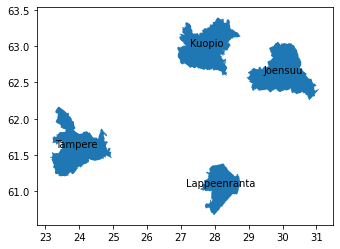

In [8]:
# Quick visualization
ax = case_areas.plot()

#Add region names
case_areas.apply(lambda x: ax.annotate(text=x["name"], 
                                       xy=x.geometry.centroid.coords[0], 
                                       ha='center'),axis=1);

## Buffers

In [9]:
fp = "../case_areas/MIKSERI_city_center_buffer_8km.geojson"
buf = gpd.read_file(fp, driver="GeoJSON")

In [10]:
buf

,Id,BufferDist,name,geometry
0,0,8.0,Tampere,"POLYGON ((23.75759 61.57053, 23.76705 61.57050..."
1,0,8.0,Joensuu,"POLYGON ((29.77490 62.67443, 29.78467 62.67397..."
2,0,8.0,Kuopio,"POLYGON ((27.68696 62.96496, 27.69685 62.96465..."
3,0,8.0,Lappeenranta,"POLYGON ((28.19452 61.13014, 28.20382 61.12979..."


## Network data

Manually fetched protobuf form mikseri case areas from [BBBike extract tool]( https://extract.bbbike.org/) following [pyrosm documentation](https://pyrosm.readthedocs.io/en/latest/basics.html#what-to-do-if-you-cannot-find-the-data-for-your-area-of-interest).

In [11]:
# Manually fetched protobuf form mikseri case areas from BBBike extract tool: https://extract.bbbike.org/
# following pyrosm documentation: https://pyrosm.readthedocs.io/en/latest/basics.html#what-to-do-if-you-cannot-find-the-data-for-your-area-of-interest
pbf_files = fp_dicts.pbf_files

In [12]:
# Get filename
print(f"Protobuf filename for {city}:")
pbf_files.get(city)

Protobuf filename for Lappeenranta:


'planet_27.828,60.916_28.692,61.186.osm.pbf'

### Custom functions for network analysis

In [13]:
def generate_graph(city, protobuf_folder, network_type="walking"):
    """Execute steps for generating nodes, edges and a pandana network from custom protobuf file"""
    
    # Start analyzing osm data from one case area
    fp = os.path.join(protobuf_folder, city, pbf_files.get(city))
    osm = OSM(fp)

    # Get odes and edges as geodataframes 
    nodes, edges = osm.get_network(network_type=network_type, nodes=True)

    network = osm.to_graph(nodes, edges, graph_type="pandana")
    
    return nodes, edges, network

In [14]:
def poi_node_id_from_osm(city, tags, protobuf_folder=r"D:\Users\E1002072\data\OSM_protobuf"):
    """Fetch points-of-interests from the pre-downloaded protobuf file"""
    
    # Start analyzing osm data from one case area
    fp = os.path.join(protobuf_folder, city, pbf_files.get(city))
    osm = OSM(fp)
    
    pois = osm.get_pois(custom_filter=tags)

    # For simplicity, ensure all restaurants are represented as points
    pois["geometry"] = pois.centroid
    pois = pois.dropna(subset=["lon", "lat"])

    # TODO CHECK FOR DUPLICATES FOR EACH CITY!
    # TODO: SAVE USED POIS TO FILE FOR FURTHER INSPECTION
    
    # Find the closest node-id for each restaurant
    node_ids = network.get_node_ids(pois.lon, pois.lat)
    
    return node_ids

In [15]:
def prepare_service_points(point_gdf, case_areas, city):
    """Prepare input points for pandana analysis"""

    # subset to case area (to avoid edge effects etc.)
    # Get rid of linear features and represent them as points..
    point_gdf["geometry"] = point_gdf.to_crs(3067).centroid.to_crs(4326)
    service = subset_result(point_gdf, case_areas, city)

    # Handle CRS
    if service.crs != CRS.from_epsg(4326):
        print("reprojecting")
        service = service.to_crs(CRS.from_epsg(4326))

    # Add/update lat lon columns
    service["lon"] = service.geometry.x
    service["lat"] = service.geometry.y
    
    return service

In [16]:
def poi_node_id_from_gdf(city, service, protobuf_folder=r"../OSM_protobuf"):
    """Fetch node ids for points in a geodataframe. Return list of node ids."""
    
    # Start analyzing osm data from one case area
    fp = os.path.join(protobuf_folder, city, pbf_files.get(city))
    osm = OSM(fp)
    
    # Find the closest node-id for each point. Max distance 1000 m from nearest network node
    node_ids = network.get_node_ids(service.lon, service.lat, mapping_distance=1000)
    
    return node_ids

In [17]:
def count_within_distance(node_ids, category_name, distance=500):
    """Execute pandana aggregated count for a set of node ids."""
    
    # Add restaurants to the graph
    network.set(node_ids, name=category_name)

    # Calculate the number of services from each node up to x meters
    result = network.aggregate(distance, type="count", name=category_name)
    result = result.to_frame(name=f"{category_name}_{distance}m")

    return result

In [18]:
def get_counts_per_node_per_service(services, service_category,distance=1000):

    service_node_ids = poi_node_id_from_gdf(city, services)

    service_count = count_within_distance(node_ids=service_node_ids, 
                                          category_name=f"count_{service_category}", 
                                          distance=distance)
    
    return service_count

In [19]:
def subset_result(result_nodes, case_areas, city):
    """Subset result points with matching case area polygon"""
    
    # Geopandas overlay, retain intersecting point geometries
    s = gpd.overlay(result_nodes.to_crs(case_areas.crs), 
                    case_areas[case_areas["name"]==city], 
                    how="intersection")
    
    return s

In [20]:
def category_count(df, selected_columns, dist, category_name="all"):
    "return pandas Series with one column that contains count of different categories (excluding category volume)"
    
    # Create simple service mix variable
    binary_counts = df[selected_columns] > 0
    binary_counts = binary_counts.replace({True:1, False:0})
    binary_counts = binary_counts.sum(axis=1)
    
    return binary_counts

In [21]:
def join_to_grid(grid, result_nodes, info_columns):
    """Summarize details from nodes to grid"""
    
    print("points before join:", len(result_nodes))

    # Do spatial join
    sjoin = gpd.sjoin(left_df=result_nodes.to_crs(grid.crs), right_df=grid, how='left', op='intersects')

    print("points after join:", len(sjoin))
    print("potential duplicates", len(sjoin) - len(sjoin.drop_duplicates(subset="id")))

    # Group info per grid square
    grouped = sjoin.groupby(by="xyind")

    # Median, mean or max... Median is probably ok for accessibility zones
    summary = grouped[info_columns].median()
    
    return summary

## Main analysis: Services within defined distance

Run one city at a time.

In [22]:
# Get data
nodes, edges, network = generate_graph(city=city, protobuf_folder=protobuf_folder)

# dataframe strutcure for results
result = nodes[['lon', 'lat', 'tags', 'id', 'geometry']]

In [23]:
# Drop columns from edges
edges = edges[["u", "v", "length", "geometry"]]

### Repeat for shapefile input (official data)

Schools, shops etc from official data sources (SYKE, Statitsics Finland).

In [24]:
# Accessibility to features stored in shapefiles..
categories = fp_dicts.shapefiles.keys()

for service_category in categories:
    
    try: 

        # Read in the points (IF NEEDED; FIX INPUT DATA AND RE-RUN!)
        file = fp_dicts.shapefiles.get(service_category)
        service_fp = os.path.join(shp_folder, file)    
        service = gpd.read_file(service_fp)

        # Get features from file
        services = prepare_service_points(service, case_areas, city)
        print(len(services), service_category, "points from", city)

        # Aggregate
        service_count = get_counts_per_node_per_service(services, service_category, distance=dist)

        result = result.merge(service_count, left_on="id", right_on=service_count.index)
    except: 
        print(f"Could not read {file}")

Could not read alakoulut.shp
Could not read ylakoulut.shp
Could not read lukiot.shp
Could not read Vähittäiskaupan_toimipaikat.shp
Could not read PT_toimipaikat.shp
Could not read Terveysasemat.shp


### Repeat for geopackage input (OpenStreetMap)

Data from OpenStreetMap.

In [25]:
# Accessibility to features stored in the OSM geopackage..

# Layernames for OSM data:
categories = fp_dicts.osm.keys()

for service_category in categories:

    layername = fp_dicts.osm.get(service_category)  
    service = gpd.read_file(osm_gpkg, layer=layername, driver="GPKG")
    
    # Get features from file
    services = prepare_service_points(service, case_areas, city)
    print(len(services), service_category, "points from", city)

    # Aggregate
    service_count = get_counts_per_node_per_service(services, service_category, distance=dist)
    
    # Add to results
    result = result.merge(service_count, left_on="id", right_on=service_count.index)

D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


13 kirjastot points from Lappeenranta


D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


14 museot points from Lappeenranta


D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


12 hotellit points from Lappeenranta


D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


2 teatterit points from Lappeenranta


D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


1 elokuvateatterit points from Lappeenranta


D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


103 ravintolat points from Lappeenranta


D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


34 kahvilat points from Lappeenranta


D:\ProgramFiles\Anaconda3\envs\python-gis\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


23 pubit_klubit points from Lappeenranta


In [26]:
# Subset to case area. Note this also re-projects data to epsg 3067 which is quite ok. 
result = subset_result(result, case_areas=case_areas, city=city)

## Calculate mix of services

a.k.a. "service baskets"; Calculate count of different services in the defined accessibility zone.
In this demo notebook, we only proces restaurants and other data from OSM. 

In [27]:
result.head(2)

,lon,lat,tags,id,count_kirjastot_1000m,count_museot_1000m,count_hotellit_1000m,count_teatterit_1000m,count_elokuvateatterit_1000m,count_ravintolat_1000m,count_kahvilat_1000m,count_pubit_klubit_1000m,Id,name,geometry
0,28.196650,61.049709,{'highway': 'traffic_signals'},14888138,0.0,0.0,2.0,0.0,0.0,18.0,4.0,4.0,0,Lappeenranta,POINT (28.19665 61.04971)
1,28.196452,61.049839,"{'bicycle': 'yes', 'crossing': 'traffic_signal...",851414253,0.0,0.0,2.0,0.0,0.0,21.0,4.0,4.0,0,Lappeenranta,POINT (28.19645 61.04984)


In [28]:
# List column names that contain the count of services 
cols = pd.Series(result.columns.values)
sel = [item for item in cols if item.startswith("count_")]
sel

['count_kirjastot_1000m',
 'count_museot_1000m',
 'count_hotellit_1000m',
 'count_teatterit_1000m',
 'count_elokuvateatterit_1000m',
 'count_ravintolat_1000m',
 'count_kahvilat_1000m',
 'count_pubit_klubit_1000m']

In [29]:
sel

['count_kirjastot_1000m',
 'count_museot_1000m',
 'count_hotellit_1000m',
 'count_teatterit_1000m',
 'count_elokuvateatterit_1000m',
 'count_ravintolat_1000m',
 'count_kahvilat_1000m',
 'count_pubit_klubit_1000m']

In [30]:
# Create simple service mix variable (count how many different types of services)
binary_counts = result[sel] > 0
binary_counts = binary_counts.replace({True:1, False:0})
binary_counts = pd.DataFrame(binary_counts.sum(axis=1), columns=[f"count_all_{dist}m"])
binary_counts

,count_all_1000m
0,4
1,4
2,5
3,5
4,6
...,...
132827,1
132828,0
132829,0
132830,0


In [31]:
result = result.join(binary_counts)

In [32]:
# Check that there area some values..
result.sort_values(by=f"count_ravintolat_{dist}m", ascending=False).head(2)

,lon,lat,tags,id,count_kirjastot_1000m,count_museot_1000m,count_hotellit_1000m,count_teatterit_1000m,count_elokuvateatterit_1000m,count_ravintolat_1000m,count_kahvilat_1000m,count_pubit_klubit_1000m,Id,name,geometry,count_all_1000m
27640,28.189592,61.055099,None,931680308,1.0,1.0,4.0,1.0,1.0,55.0,21.0,16.0,0,Lappeenranta,POINT (28.18959 61.05510),8
63362,28.189178,61.055262,None,2503864938,1.0,1.0,4.0,1.0,1.0,55.0,21.0,16.0,0,Lappeenranta,POINT (28.18918 61.05526),8


In [33]:
lahipalvelut = ['alakoulut',
                'paivittaistavarakauppa (Nielsen 2018)', 
                'kirjastot', 
                'terveysasemat'
                # Logically, this category could include also kindergartens etc. if available
               ]

sel_cols = [f'count_{service}_{dist}m' for service in lahipalvelut]
category = "lahipalvelut"

In [34]:
# Uncomment if there is data about these services
#result[f"count_lahipalvelut_{dist}m"] = category_count(result, sel_cols, dist=dist, category_name=category)

In [35]:
ravintolat_ja_viihde = [ 
 'teatterit',
 'elokuvateatterit',
 'ravintolat',
 'kahvilat',
 'pubit_klubit',
#'museot',
]

sel_cols = [f'count_{service}_{dist}m' for service in ravintolat_ja_viihde]
category = "raflat_ja_viihde"

In [36]:
result[f"count_raflatjaviihde_{dist}m"] = category_count(result, sel_cols, dist=dist, category_name=category)

In [37]:
# Save nodes to file
if save_points == True:
    folder = r"../results"
    file = f"{city}_service_diversity_{dist}m_zone.shp"
    result.to_file(os.path.join(folder, file))

## Visualize results

In [38]:
visualize = True # DO NOT RUN THE REST OF THE NOTEBOOK..
if visualize == False:
    exit()

In [39]:
# Custom zoom extent for cropping the imgs:
bbox_dict_region = {"Lappeenranta" :(3108726, 8615474, 3167898, 8670365),
                          "Tampere" :(2565965.504816361,  8666622.851779206, 2778613.9038550477, 8823231.117911933, "region"),
                          "Joensuu" :(634220,6935025,650761,6950450),
                          "Kuopio" : (3050487,9047832, 3106766, 9100097),
                        }

bbox=bbox_dict_region.get(city)
#folder=closest-service-city-zoom

In [40]:
 #BBOX FROM 8 km buffer
# work in local projected CRS 
buf = buf.to_crs(3067)
bbox = buf.loc[buf["name"]==city].bounds
bbox = bbox.values[0]

In [41]:
bins = [1, 2, 3]

In [42]:
def plot_node_results(result, column=f"count_all_{dist}m", title_text=f"Eri tyyppisiä palveluita {dist} m kävelyetäisyydellä"):    
    
    markersize = 2.2
    linewidth = 1.5

    cartodb_url='https://{s}.basemaps.cartocdn.com/rastertiles/voyager_nolabels/{z}/{x}/{y}{r}.png'
    credits = "Taustakartta: © OpenStreetMapin tekijät, © CARTO"
    legend_title =f"Erilaisia palveluita,\n{dist} m kävely"

    # Visualize the results
    plt.style.use('default')

    ax = result[result[column]>0].to_crs(buf.crs).plot(column=column, 
                #cmap='YlOrRd', 
                #cmap='hot',
                #cmap="viridis",
                cmap="Reds",
                markersize=markersize, 
                legend=True, 
                figsize=(15, 15), 
                #scheme="naturalbreaks", 
                #k=5,
                scheme="user_defined", 
                classification_kwds={'bins':bins},
                legend_kwds=dict(loc='upper right',
                fontsize='x-large', title=legend_title)
                    )

    buf.loc[buf["name"]==city].plot(ax=ax, facecolor="none", edgecolor="black", linestyle="--", linewidth=linewidth)

    # Add basemap
    ctx.add_basemap(ax, zoom=13, source=cartodb_url, 
                    crs=buf.crs.to_string(), 
                    attribution=credits,
                   attribution_size=14)

    ax.set_xlim(bbox[0], bbox[2])
    ax.set_ylim(bbox[1], bbox[3])

    ax.add_artist(ScaleBar(1, location="lower right", box_alpha=0.5))

    plt.title(title_text, fontsize=30)
    
    ax.get_legend().get_title().set_fontsize('20') #legend 'Title' fontsize
    plt.setp(plt.gca().get_legend().get_texts(), fontsize='18') #legend 'list' fontsize

    plt.axis('off')
    plt.tight_layout()
    
    category = column.split("_")[1]

    plt.savefig(fr"../img/{city}_palvelumix_{category}_{dist}_m.png")

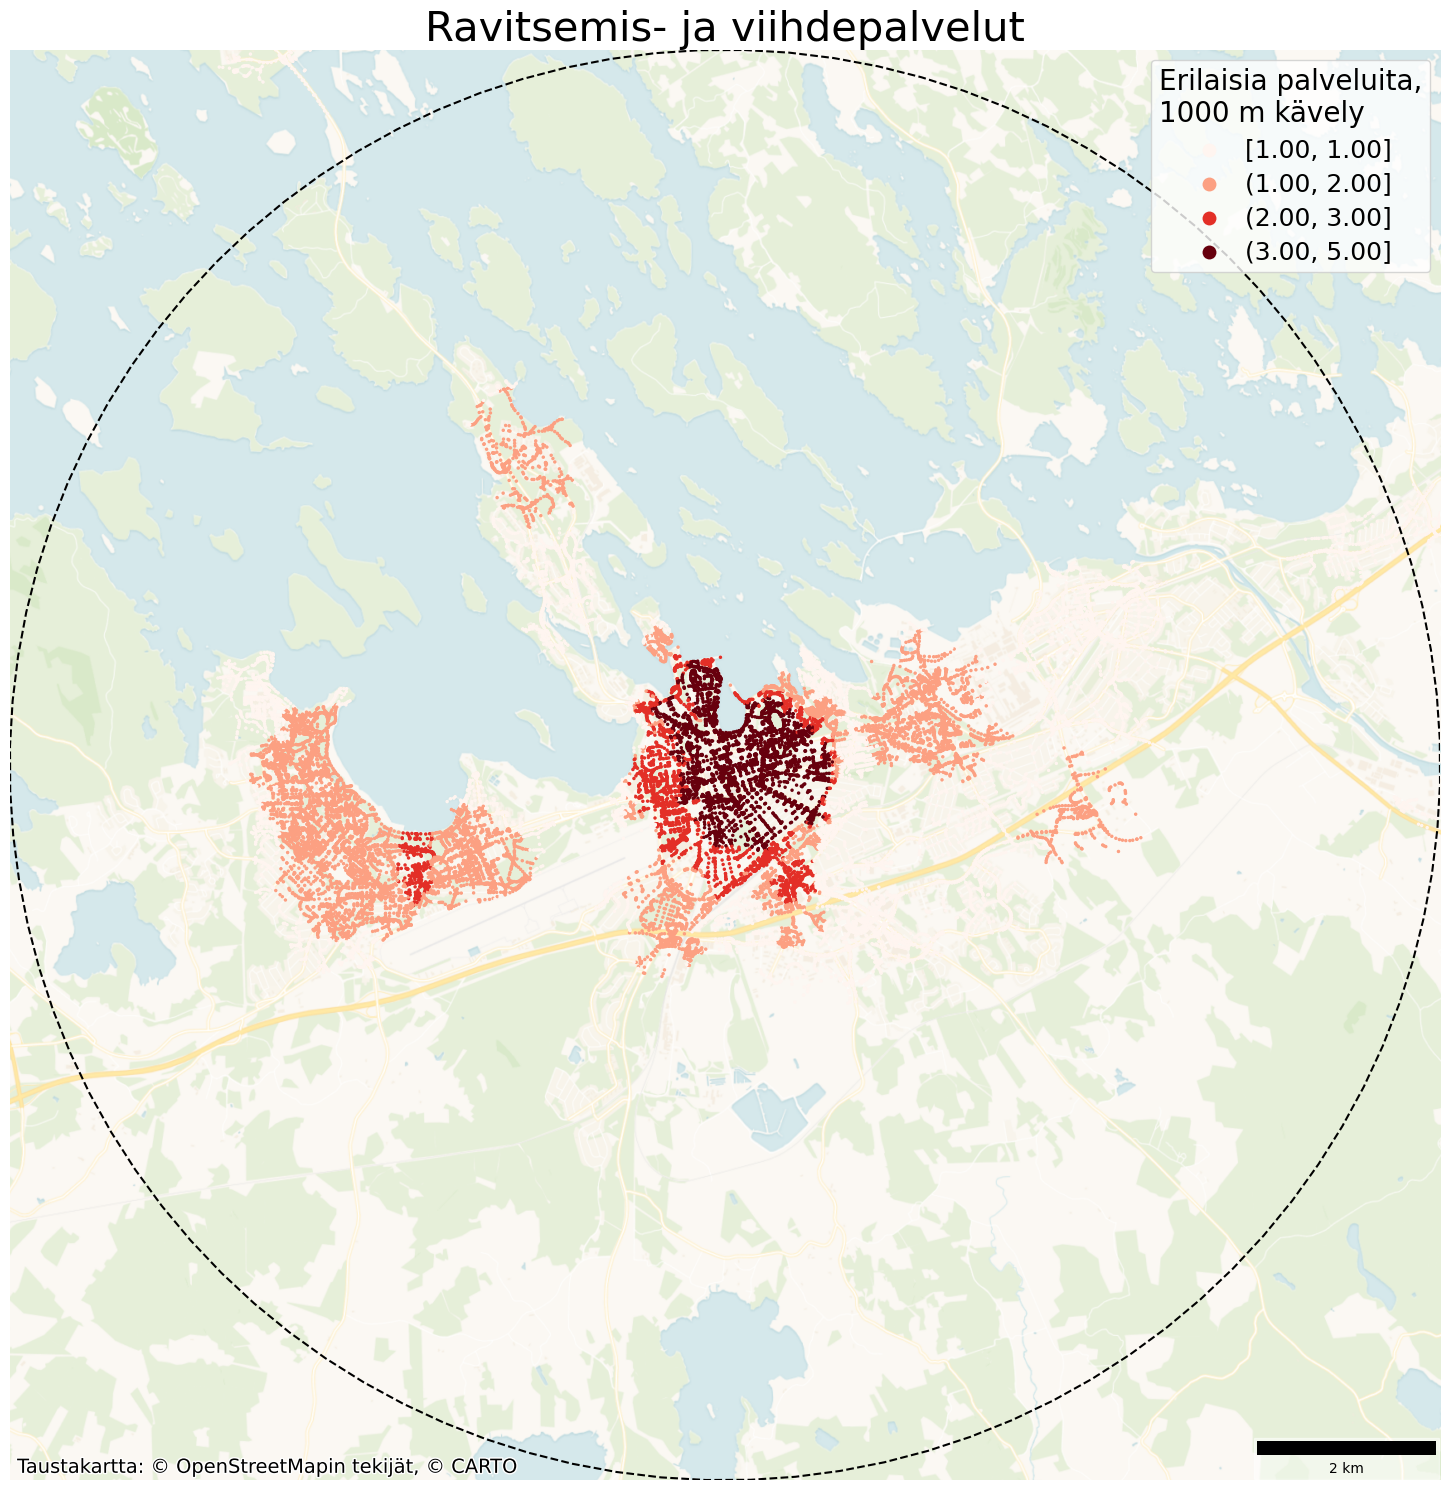

In [43]:
plot_node_results(result, column=f"count_raflatjaviihde_{dist}m", title_text=f"Ravitsemis- ja viihdepalvelut")
#plot_node_results(result, column=f"count_lahipalvelut_{dist}m", zoom=zoomlevel, title_text=f"Lähipalvelut")
#plot_node_results(result, column=f"count_all_{dist}m", zoom=zoomlevel, title_text=f"Eri tyyppisiä palveluita {dist} m kävelyetäisyydellä")